In [1]:
import sys


sys.path.append("../src/")

In [2]:
from sennet.custom_modules.metrics.surface_dice_metric_fast import create_table_neighbour_code_to_surface_area
import numpy as np
import torch
import torch.nn as nn

In [3]:
device = "cuda"

In [4]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-3):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, input, target):
        # Apply sigmoid to input (predictions)
        input_sigmoid = torch.sigmoid(input).reshape(-1)
        target_flat = target.reshape(-1)
        
        intersection = (input_sigmoid * target_flat).sum()

        return 1 - (
            (2.0 * intersection + self.smooth)
            / (input_sigmoid.sum() + target_flat.sum() + self.smooth)
        )


class SurfaceDiceLoss(nn.Module):
    def __init__(self, smooth=1e-3, device="cuda"):
        nn.Module.__init__(self)
        self.smooth = smooth
        self.area = create_table_neighbour_code_to_surface_area((1, 1, 1))[1:]
        self.area = torch.from_numpy(self.area).to(device)  # torch.float32
        self.unfold = torch.nn.Unfold(kernel_size=(2, 2), padding=1)
        self.bases = torch.tensor([
            [c=="1" for c in f"{i:08b}"]
            for i in range(1, 256)
        ]).float().permute((1, 0)).to(device)

    def _forward_z_pair(self, pred, labels):
        # pred = (batch, z, y, x): logits
        # labels = (batch, z, y, x): labels (0 or 1 only)

        # assert shapes
        batch_size, zs, ys, xs = pred.shape

        # unfold: group 8 corners together
        pred_sigmoid = torch.sigmoid(pred)
        unfolded_pred = self.unfold(pred_sigmoid)
        unfolded_labels = self.unfold(labels.float())
        permuted_unfolded_pred = unfolded_pred.permute((0, 2, 1)).unsqueeze(-1)

        # assert shapes
        batch_size, n_points, n_corners, _ = permuted_unfolded_pred.shape
        assert n_corners == 8, f"{n_corners=} != 8 ({permuted_unfolded_pred.shape=}, {unfolded_pred.shape=}, {pred.shape=})"

        # solve for bases weights
        a_mat = self.bases.tile((batch_size, n_points, 1, 1)).float()
        b_mat = permuted_unfolded_pred.float()
        bases_weights = torch.linalg.lstsq(a_mat, b_mat).solution

        # weighted sum to get pred areas
        pred_areas = (self.area[None, None, :, None] * bases_weights).squeeze(-1).sum(2)

        # compute label areas
        label_cubes_byte = torch.zeros((unfolded_labels.shape[0], unfolded_labels.shape[2]), dtype=torch.int32, device=device)
        for k in range(8):
            label_cubes_byte += unfolded_labels[:, k, :].to(torch.int32) << k

        label_areas = torch.zeros((label_cubes_byte.shape[0], label_cubes_byte.shape[1]), dtype=torch.float32, device=device)
        for b in range(label_cubes_byte.shape[0]):
            label_areas[b, :] = torch.where(label_cubes_byte[b, :] == 0, label_areas[b, :], self.area[label_cubes_byte[b, :] - 1])

        # computing intersections
        #  intersection = area of the label cube * bases weight at that cube in pred
        intersection = torch.zeros((bases_weights.shape[0], bases_weights.shape[1]), device=device, dtype=torch.float32)
        for i in range(bases_weights.shape[0]):
            w = bases_weights[i, ...].squeeze(-1)  # (points, 255)
            cb = label_cubes_byte[i, ...]   # (points, )
            weight_at_label_cube = torch.where(
                cb==0, 
                torch.zeros((w.shape[0], ), dtype=torch.float32, device=device), 
                w[torch.arange(w.shape[0], device=device), cb-1]
            )
            intersection[i, ...] = weight_at_label_cube * label_areas[i, ...]

        # TODO(Sumo): check if sum make sense here
        numerator = 2 * intersection.sum()
        denominator = label_areas.sum() + pred_areas.sum()
        return numerator, denominator

    def forward(self, pred, labels):
        batch_size, zs, ys, xs = pred.shape
        assert pred.shape == labels.shape
        assert zs >= 2, f"zs not >= 2, {pred.shape=}"
        num = 0
        denom = 0
        for z_start in range(zs):
            z_end = z_start + 2
            if z_end >= zs:
                break
            pair_num, pair_denom = self._forward_z_pair(pred[:, z_start: z_end, ...], labels[:, z_start: z_end, ...])
            num += pair_num
            denom += pair_denom
        dice = 1 - ((num + self.smooth) / (denom + self.smooth))
        return dice 

In [5]:
def build_sphere_data(cube_size: int, center_zyx: np.ndarray, radius: int):
    # arr = np.zeros((cube_size, cube_size, cube_size))
    zs, ys, xs = np.meshgrid(
        np.arange(cube_size),
        np.arange(cube_size),
        np.arange(cube_size),
        indexing="ij",
    )
    arr = (
        (zs-center_zyx[0])**2
        + (ys-center_zyx[1])**2
        + (xs-center_zyx[2])**2
    ) ** 0.5
    label = arr < radius
    return arr, label

In [6]:
import matplotlib.pyplot as plt

In [7]:
class SphereDataset(torch.utils.data.Dataset):
    def __init__(self, cube_size: int, radius: int, length: int = 1000):
        self.cube_size = cube_size
        self.radius = radius
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, i):
        center_zyx = np.random.uniform(0, self.cube_size, 3)
        img, seg = build_sphere_data(self.cube_size, center_zyx, self.radius)
        img = torch.from_numpy(img).float().unsqueeze(0)
        seg = torch.from_numpy(seg).float().unsqueeze(0)
        return {
            "img": img,
            "seg": seg,
        }

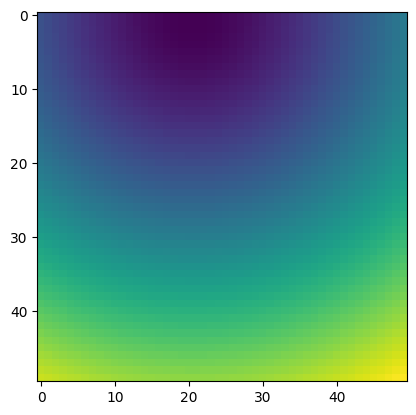

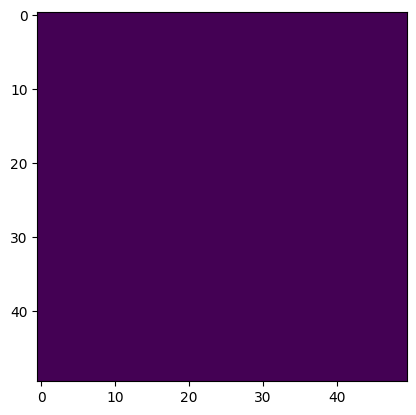

In [8]:
d = SphereDataset(50, 10)
i = 25
item = d[25]
plt.imshow(item["img"].cpu().numpy()[0][i, ...])
plt.figure()
plt.imshow(item["seg"].cpu().numpy()[0][i, ...])

In [9]:
from sennet.custom_modules.models.wrapped_models import WrappedUNet3D, SMPModel
from sennet.core.submission_utils import evaluate_chunked_inference_in_memory

In [10]:
import pytorch_lightning as pl


class ThreeDSegTask(pl.LightningModule):
    def __init__(self, model, criterion, val_dataloader, input_key: str = "img"):
        pl.LightningModule.__init__(self)
        self.model = model
        self.criterion = criterion
        self.val_dataloader = val_dataloader
        self.input_key = input_key

    def training_step(self, batch: dict, batch_idx: int):
        self.model = self.model.train()

        seg_pred = self.model.predict(batch[self.input_key])
        preds = seg_pred.pred
        gt_seg_map = batch["seg"].float()

        _, pred_d, pred_h, pred_w = preds.shape
        _, _, gt_d, gt_h, gt_w = gt_seg_map.shape
        if (gt_d != pred_d) or (gt_h != pred_h) or (gt_w != pred_w):
            raise RuntimeError(":D")
        else:
            resized_pred = preds

        loss = self.criterion(resized_pred, gt_seg_map[:, 0, ...])
        self.log_dict({"train_loss": loss,}, prog_bar=True)
        return loss

    def validation_step(self, batch: dict, batch_idx: int):
        return

    def on_validation_epoch_end(self) -> None:
        with torch.no_grad():
            self.model = self.model.eval()

            metrics = None
            val_loss = None
            for batch in self.val_dataloader:
                pred = self.model.predict(batch[self.input_key].to(self.device))
                gt_seg_map = batch["seg"].float().to(self.device)

                metrics = evaluate_chunked_inference_in_memory(
                    mean_prob_chunk=torch.sigmoid(pred.pred[0]).cpu().numpy(),
                    label=gt_seg_map[0, 0, ...].cpu().numpy().astype(bool),
                    thresholds=[0.5],
                    device="cuda",
                )
                val_loss = self.criterion(pred.pred, gt_seg_map[:, 0, ...])

                break  # only eval one cube

            print("--------------------------------")
            print(f"{metrics = }")
            print(f"{val_loss = }")
            print("--------------------------------")

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=1e-3, eps=1e-8)

In [11]:
cube_size = 64


train_dataset = SphereDataset(cube_size, 10, length=500)
val_dataset = SphereDataset(cube_size, 10, length=1)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)
model = SMPModel(
    "Unet",
    encoder_name="resnet34",
    encoder_weights="imagenet",
    replace_batch_norm_with_layer_norm=True,
    in_channels=cube_size,
    classes=cube_size,
).to(device).train()

In [12]:
# criterion = nn.BCEWithLogitsLoss()   # 0.86
# criterion = DiceLoss()  # 0.92
criterion = SurfaceDiceLoss(device=device)
input_key = "seg"
task = ThreeDSegTask(model, criterion, val_loader, input_key)

In [13]:
trainer = pl.Trainer(
    accelerator="gpu",
    logger=None,
    max_epochs=10,
    precision="16",
    benchmark=True,
    devices=-1,
)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    model=task,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

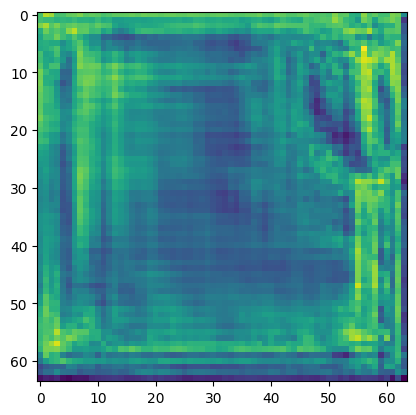

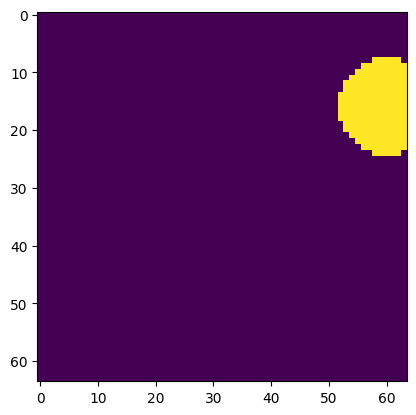

In [14]:
trained_model = task.model.eval()

with torch.no_grad():
    val_item = val_dataset[0]
    val_img = val_item[input_key]
    val_label = val_item["seg"][0]
    model_out = trained_model.predict(val_img.unsqueeze(0).to(device))
    pred = model_out.pred[0].cpu().numpy()


i = 32

plt.imshow(pred[i, ...])
plt.figure()
plt.imshow(val_label[i, ...])

In [15]:
pred.shape

(64, 64, 64)

In [16]:
val_label.shape

torch.Size([64, 64, 64])

In [19]:
from torch.profiler import profile, record_function, ProfilerActivity


criterion(
    val_label.unsqueeze(0).to(device), 
    val_label.unsqueeze(0).to(device),
)

tensor(1.0001, device='cuda:0')